In [66]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') # Open Multilingual Wordnet
nltk.download('vader_lexicon') # Lexicon for VADER sentiment analysis

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Define column names based on the dataset's apparent structure
column_names = ['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_Text']

In [4]:
file_path = 'twitter_training.csv'

In [5]:
# Load the dataset, skipping the first row and providing the column names
try:
    df_train = pd.read_csv(file_path, header=None, names=column_names, skiprows=1)
    print(f"\nDataset '{file_path}' loaded successfully by skipping the first row and assigning custom headers.")
except FileNotFoundError:
    print(f"\nError: '{file_path}' not found. Please ensure the file is uploaded directly to the Colab session storage.")
    # Exit or handle the error appropriately if the file isn't found
    import sys
    sys.exit("Exiting due to file not found error.")


Dataset 'twitter_training.csv' loaded successfully by skipping the first row and assigning custom headers.


In [64]:
print("\n2.1: First 5 rows of the dataset")
print(df_train.head())


2.1: First 5 rows of the dataset
   Tweet_ID       Entity Sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                          Tweet_Text  
0  I am coming to the borders and I will kill you...  
1  im getting on borderlands and i will kill you ...  
2  im coming on borderlands and i will murder you...  
3  im getting on borderlands 2 and i will murder ...  
4  im getting into borderlands and i can murder y...  


In [63]:
print("\n2.2: Dataset Information (Columns, Non-Null Counts, Dtypes)")
print(df_train.info())


2.2: Dataset Information (Columns, Non-Null Counts, Dtypes)
<class 'pandas.core.frame.DataFrame'>
Index: 73995 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tweet_ID    73995 non-null  int64 
 1   Entity      73995 non-null  object
 2   Sentiment   73995 non-null  object
 3   Tweet_Text  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB
None


Section 3: Data Cleaning and Filtering for Problem Statement

In [8]:
print("\n3.1: Missing values count per column (before cleaning)")
print(df_train.isnull().sum())


3.1: Missing values count per column (before cleaning)
Tweet_ID        0
Entity          0
Sentiment       0
Tweet_Text    686
dtype: int64


In [9]:
# Drop rows where 'Tweet_Text' is NaN (missing), as they cannot be analyzed for sentiment.
df_train.dropna(subset=['Tweet_Text'], inplace=True)
print("\n3.2: Missing values after dropping rows with null 'Tweet_Text' ")
print(df_train.isnull().sum())
print(f"Dataset shape after dropping nulls: {df_train.shape}")


3.2: Missing values after dropping rows with null 'Tweet_Text' 
Tweet_ID      0
Entity        0
Sentiment     0
Tweet_Text    0
dtype: int64
Dataset shape after dropping nulls: (73995, 4)


In [10]:
# Analyze the overall sentiment distribution
print("\n3.3: Overall Sentiment Distribution in the training dataset")
print(df_train['Sentiment'].value_counts())
print("\n3.4: Overall Sentiment Distribution as Percentage")
print(df_train['Sentiment'].value_counts(normalize=True) * 100)


3.3: Overall Sentiment Distribution in the training dataset
Sentiment
Negative      22358
Positive      20654
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

3.4: Overall Sentiment Distribution as Percentage
Sentiment
Negative      30.215555
Positive      27.912697
Neutral       24.471924
Irrelevant    17.399824
Name: proportion, dtype: float64


In [11]:
# Filter the dataset to include only tweets specifically related to 'Borderlands'.
# This directly addresses your assignment's problem statement.
# We use .copy() to avoid SettingWithCopyWarning in future operations.
borderlands_df = df_train[df_train['Entity'].str.contains('Borderlands', case=False, na=False)].copy()

In [12]:
borderlands_df.reset_index(drop=True, inplace=True)

In [60]:
print(f"\n3.5: Shape of 'Borderlands' specific dataset: {borderlands_df.shape}")
print("\n3.6: First 5 rows of 'Borderlands' specific dataset")
print(borderlands_df.head())


3.5: Shape of 'Borderlands' specific dataset: (2039, 7)

3.6: First 5 rows of 'Borderlands' specific dataset
   Tweet_ID       Entity Sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                          Tweet_Text  \
0  I am coming to the borders and I will kill you...   
1  im getting on borderlands and i will kill you ...   
2  im coming on borderlands and i will murder you...   
3  im getting on borderlands 2 and i will murder ...   
4  im getting into borderlands and i can murder y...   

             Cleaned_Tweet_Text VADER_Sentiment  Cluster  
0            coming border kill        Negative        0  
1    im getting borderland kill        Negative        0  
2   im coming borderland murder        Negative        0  
3  im getting borderland murder        Negative        0  
4  im getting borderland murd

In [62]:
print("\n3.7: Sentiment Distribution for 'Borderlands' tweets")
print(borderlands_df['Sentiment'].value_counts())
print("\n3.8: Sentiment Distribution as Percentage for 'Borderlands' tweets")
print(borderlands_df['Sentiment'].value_counts(normalize=True) * 100)


3.7: Sentiment Distribution for 'Borderlands' tweets
Sentiment
Positive    1016
Neutral      597
Negative     426
Name: count, dtype: int64

3.8: Sentiment Distribution as Percentage for 'Borderlands' tweets
Sentiment
Positive    49.828347
Neutral     29.279058
Negative    20.892594
Name: proportion, dtype: float64


In [61]:
# Ensure only 'Positive', 'Negative', 'Neutral' sentiments are kept, aligning with the problem statement.
valid_sentiments = ['Positive', 'Negative', 'Neutral']
borderlands_df = borderlands_df[borderlands_df['Sentiment'].isin(valid_sentiments)].copy()
print(f"\n3.9: Shape after ensuring only Positive/Negative/Neutral sentiments: {borderlands_df.shape}")


3.9: Shape after ensuring only Positive/Negative/Neutral sentiments: (2039, 7)


Section 4: Text Preprocessing for Sentiment Analysis

In [16]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [17]:
def preprocess_text(text):
    """
    Cleans and preprocesses tweet text.
    Handles lowercasing, URL/mention/hashtag removal, punctuation, numbers,
    emojis (basic removal), stopwords, and lemmatization.
    This process is essential for preparing noisy social media data for analysis.
    """
    # 1. Lowercasing
    text = text.lower()

    # 2. Remove URLs (http/https links)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # 4. Remove hashtags (#hashtag) - keeping text for now as sentiment might be in them.
    text = re.sub(r'#', '', text)

    # 5. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 6. Remove numbers
    text = re.sub(r'\d+', '', text)

    # 7. Remove emojis (basic removal)
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)

    # 8. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # 9. Remove stopwords
    # Tokenize the text first to remove stopwords effectively
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    text = ' '.join(tokens)

    # 10. Lemmatization
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)

    return text

In [57]:
print("\n4.1: Applying text preprocessing to 'Tweet_Text' column")
borderlands_df['Cleaned_Tweet_Text'] = borderlands_df['Tweet_Text'].apply(preprocess_text)


4.1: Applying text preprocessing to 'Tweet_Text' column


In [58]:
print("\n4.2: Original vs. Cleaned Tweets Sample")
for i in range(5):
    print(f"Original: {borderlands_df['Tweet_Text'].iloc[i]}")
    print(f"Cleaned:  {borderlands_df['Cleaned_Tweet_Text'].iloc[i]}\n")


4.2: Original vs. Cleaned Tweets Sample
Original: I am coming to the borders and I will kill you all,
Cleaned:  coming border kill

Original: im getting on borderlands and i will kill you all,
Cleaned:  im getting borderland kill

Original: im coming on borderlands and i will murder you all,
Cleaned:  im coming borderland murder

Original: im getting on borderlands 2 and i will murder you me all,
Cleaned:  im getting borderland murder

Original: im getting into borderlands and i can murder you all,
Cleaned:  im getting borderland murder



Section 5: Unsupervised Sentiment Analysis (Lexicon-Based Approach)

In [20]:
analyzer = SentimentIntensityAnalyzer()

In [21]:
def get_vader_sentiment(text):
    """
    Applies VADER sentiment intensity analyzer to get a compound sentiment score.
    Maps the compound score to 'Positive', 'Negative', or 'Neutral' categories.
    """
    vs = analyzer.polarity_scores(text)
    compound_score = vs['compound']
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [49]:
print("\n5.1: Applying VADER Sentiment Analysis")
borderlands_df['VADER_Sentiment'] = borderlands_df['Cleaned_Tweet_Text'].apply(get_vader_sentiment)


5.1: Applying VADER Sentiment Analysis


In [48]:
print("\n5.2: VADER Sentiment Distribution for Borderlands tweets")
print(borderlands_df['VADER_Sentiment'].value_counts())
print("\n5.3: VADER Sentiment Distribution as Percentage")
print(borderlands_df['VADER_Sentiment'].value_counts(normalize=True) * 100)


5.2: VADER Sentiment Distribution for Borderlands tweets
VADER_Sentiment
Positive    1152
Negative     554
Neutral      333
Name: count, dtype: int64

5.3: VADER Sentiment Distribution as Percentage
VADER_Sentiment
Positive    56.498283
Negative    27.170181
Neutral     16.331535
Name: proportion, dtype: float64


In [56]:
print("\n5.4: Comparison of VADER Sentiment with Original Labels")
if 'Sentiment' in borderlands_df.columns:
    comparison_df = borderlands_df[['Sentiment', 'VADER_Sentiment']]
    # Cross-tabulation can show how VADER's labels align with the original labels
    print(pd.crosstab(comparison_df['Sentiment'], comparison_df['VADER_Sentiment']))
else:
    print("Original 'Sentiment' column not found for comparison.")


5.4: Comparison of VADER Sentiment with Original Labels
VADER_Sentiment  Negative  Neutral  Positive
Sentiment                                   
Negative              224       74       128
Neutral               179      122       296
Positive              151      137       728


/tmp/ipython-input-25-4228127670.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=borderlands_df, x='VADER_Sentiment', order=['Positive', 'Neutral', 'Negative'], palette='viridis')


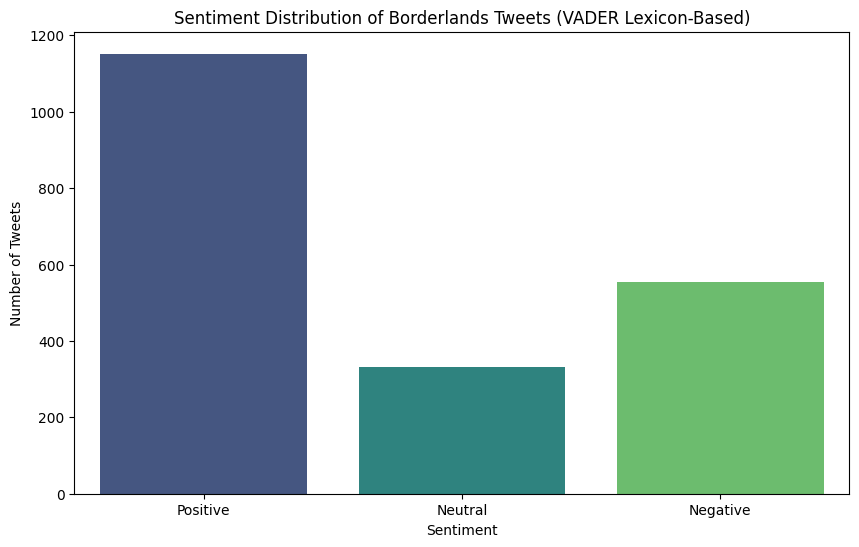

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(data=borderlands_df, x='VADER_Sentiment', order=['Positive', 'Neutral', 'Negative'], palette='viridis')
plt.title('Sentiment Distribution of Borderlands Tweets (VADER Lexicon-Based)')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

Section 6: Unsupervised Learning (Clustering with K-Means)

In [50]:
print("\n6.1: Preparing data for Clustering (TF-IDF Vectorization)")
# Use the same TF-IDF vectorizer as before to represent text numerically
tfidf_vectorizer_clustering = TfidfVectorizer(max_features=5000, min_df=5, sublinear_tf=True)
X_clustering = tfidf_vectorizer_clustering.fit_transform(borderlands_df['Cleaned_Tweet_Text'])


6.1: Preparing data for Clustering (TF-IDF Vectorization)


In [51]:
print(f"Shape of TF-IDF feature matrix for clustering: {X_clustering.shape}")

Shape of TF-IDF feature matrix for clustering: (2039, 1260)


In [42]:
num_clusters = 4

In [52]:
print(f"\n6.2: Applying K-Means Clustering with K={num_clusters}")
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
borderlands_df['Cluster'] = kmeans_model.fit_predict(X_clustering)


6.2: Applying K-Means Clustering with K=4


In [53]:
print("\n6.3: Cluster Distribution")
print(borderlands_df['Cluster'].value_counts())


6.3: Cluster Distribution
Cluster
0    1294
1     374
3     323
2      48
Name: count, dtype: int64


In [54]:
def get_top_terms_per_cluster(model, vectorizer, n_terms=10):
    """
    Prints the top N terms for each cluster based on the cluster centers.

    Args:
        model (KMeans): The trained K-Means model.
        vectorizer (TfidfVectorizer): The TF-IDF vectorizer used to transform the text.
        n_terms (int): The number of top terms to display for each cluster.
    """
    terms = vectorizer.get_feature_names_out()
    print(f"Displaying top {n_terms} keywords for each cluster based on cluster centroids:")
    for i, center in enumerate(model.cluster_centers_):
        top_terms_idx = center.argsort()[-n_terms:][::-1] # Get indices of top terms
        top_terms = [terms[idx] for idx in top_terms_idx] # Map indices to term names
        print(f"Cluster {i}")
        print(f"Keywords: {', '.join(top_terms)}")

# Call the function with your trained KMeans model and TF-IDF vectorizer
get_top_terms_per_cluster(kmeans_model, tfidf_vectorizer_clustering)

Displaying top 10 keywords for each cluster based on cluster centroids:
Cluster 0
Keywords: borderland, game, love, good, like, im, best, really, time, today
Cluster 1
Keywords: new, fun, dlc, borderland, work, one, happy, love, much, game
Cluster 2
Keywords: fuck, coming, bioshock, count, bitch, borderland, march, joke, somethin, remember
Cluster 3
Keywords: play, get, borderland, please, game, fix, cant, really, xbox, im


In [55]:
# Higher silhouette score indicates better-defined clusters.
if X_clustering.shape[0] > 1 and num_clusters > 1: # Ensure enough samples and clusters for score calculation
    silhouette_avg = silhouette_score(X_clustering, borderlands_df['Cluster'])
    print(f"\n6.4: Silhouette Score for K-Means: {silhouette_avg:.4f}")
else:
    print("\n6.4: Skipping Silhouette Score calculation (not enough samples/clusters)")

print("\n6.5: Sample Tweets from each Cluster (for manual interpretation)")
for cluster_id in sorted(borderlands_df['Cluster'].unique()):
    print(f"\nCluster {cluster_id} Samples")
    cluster_samples = borderlands_df[borderlands_df['Cluster'] == cluster_id]['Tweet_Text'].sample(min(5, len(borderlands_df[borderlands_df['Cluster'] == cluster_id])), random_state=42)
    for sample_text in cluster_samples:
        print(f"- {sample_text}")


6.4: Silhouette Score for K-Means: 0.0163

6.5: Sample Tweets from each Cluster (for manual interpretation)

Cluster 0 Samples
- A friendly reminder that the track Borderlands 3 is an absolute banger and this song is special is probably my favorite gag of the whole game... youtu.be / nFwAmB-tluI
- <unk> bURn Bookmark tHe permalink <unk>.
- Darth The Filius unlocked 1 official achievement app in Borderlands3 2018 and increased their gamerscore with 15 to 595 in to that game and 40029 total
- I love u bro
- The best gaming deals today: FIFA 20 $18, Borderlands Handsome $15, more - 9to5Toys uk.googlehits.com / as-we-speak-f...

Cluster 1 Samples
- Borderlands 3'′ s personal Lovecraft series DLC 2 Dismisses various Major Problems Associated With The Whole Author's Work snip. br ly / o24fq7? utm _ sou … for https://t.co/IGbpAJ3HzD ]
- One of our shows own @ProfZeroo is live via w / at @borderlands 3 and [UNK].... Catch him here : the buff. ly / to 2WmmiP5.. to Say " Streamer Shouts " in ch

/tmp/ipython-input-47-1945319203.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=borderlands_df, x='Cluster', palette='viridis')


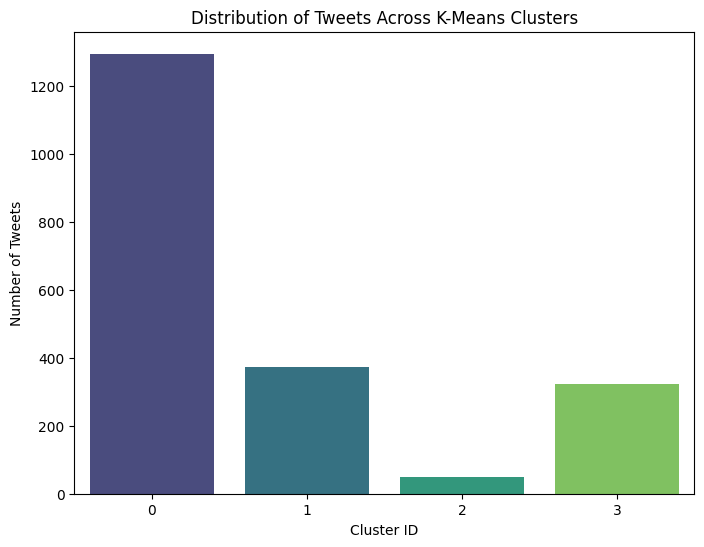

In [47]:
# Plotting cluster distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=borderlands_df, x='Cluster', palette='viridis')
plt.title('Distribution of Tweets Across K-Means Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Tweets')
plt.show()

In [68]:
svd = TruncatedSVD(n_components=2, random_state=42)
# Apply SVD on the TF-IDF feature matrix (X_clustering)
X_2D = svd.fit_transform(X_clustering)

In [69]:
print(f"Shape of reduced 2D data: {X_2D.shape}")

Shape of reduced 2D data: (2039, 2)


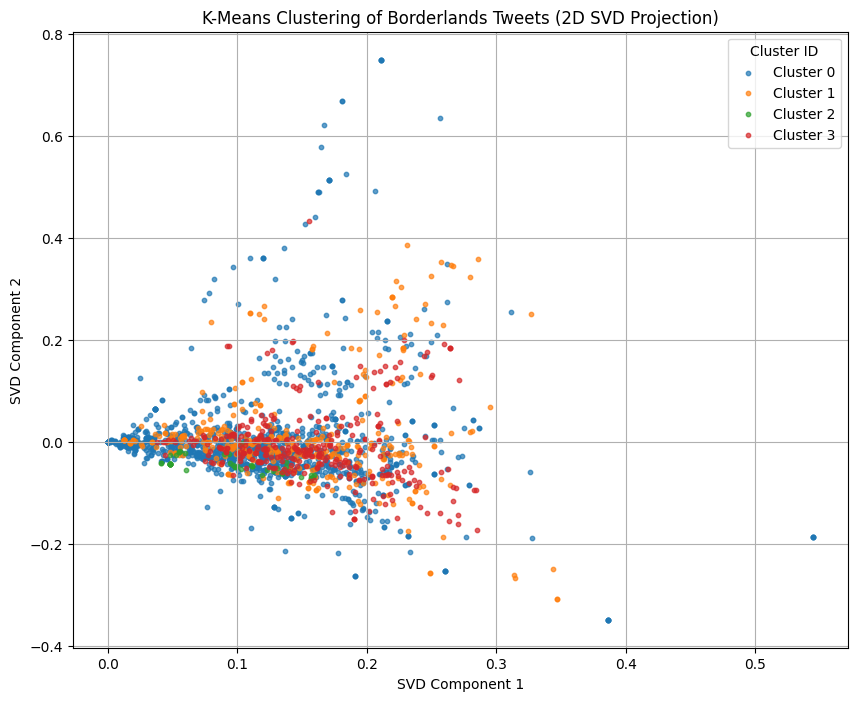

In [70]:
# Plot the reduced 2D data points, colored by cluster
plt.figure(figsize=(10, 8))

# Define colors for clusters. Using seaborn's palette for robustness with more clusters.
palette = sns.color_palette("tab10", num_clusters) # 'tab10' provides 10 distinct colors

for i in range(num_clusters): # Iterate through the number of clusters
    plt.scatter(
        X_2D[borderlands_df["Cluster"] == i, 0], # Select x-coordinates for current cluster
        X_2D[borderlands_df["Cluster"] == i, 1], # Select y-coordinates for current cluster
        s=10, # Size of markers
        c=[palette[i]], # Color for the current cluster
        label=f"Cluster {i}", # Label for the legend
        alpha=0.7 # Transparency
    )

plt.title("K-Means Clustering of Borderlands Tweets (2D SVD Projection)")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.legend(title="Cluster ID")
plt.grid(True)
plt.show()